In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

#BiocManager::install("treeio")
#BiocManager::install("ggtree")
#BiocManager::install("ggtreeExtra")
#BiocManager::install("Biostrings")
#BiocManager::install("XVector")

#install.packages("tidyverse")
#install.packages("ggplot2")
#install.packages("ggstance")
#install.packages("ggmsa")
#install.packages("seqmagick")
#install.packages("shiny")
#install.packages("DT")
#install.packages("cowplot")
#install.packages("ggplotify")
#install.packages("shinydashboard")
#install.packages("shinydashboardPlus") # > 2.0
#install.packages("fontawesome")
#install.packages("UpSetR")
#install.packages("ggvenn")
###install.packages("plotly")
#install.packages("shinyjs")
#install.packages("svglite")
#install.packages("ggmsa")
#install.packages("ggstar")
##install.packages("ggnewscale")
##install.packages("Polychrome")
###install.packages("gridSVG")
#install.packages("svgPanZoom")
###install.packages("rbokeh")
###install.packages("ggiraph")
###install.packages("VennDiagram")

In [1]:
library(treeio)
library(ggtree)
library(ggtreeExtra)
library(ggstar)
library(ggnewscale)
library(tidyverse)
library(ggplot2)
library(ggstance)
library(Biostrings)
library(ggmsa)
library(seqmagick)
library(XVector)
library(gtable)
library(grid)
library(shiny)
library(DT)
library(cowplot)
library(ggplotify)
library(shinydashboard)
library(shinydashboardPlus)
library(fontawesome)
library(UpSetR)
library(ggvenn)
#library(plotly)
library(shinyjs)
library(ggmsa)
library(Polychrome)
#library(svgPanZoom)
#library(svglite)
#library(gridSVG)
###library(echarts4r)
###library(ggiraph)
###library(rbokeh)
###library(VennDiagram)
###

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

treeio v1.13.1  For help: https://yulab-smu.github.io/treedata-book/

If you use treeio in published research, please cite:

LG Wang, TTY Lam, S Xu, Z Dai, L Zhou, T Feng, P Guo, CW Dunn, BR Jones, T Bradley, H Zhu, Y Guan, Y Jiang, G Yu. treeio: an R package for phylogenetic tree input and output with richly annotated and associated data. Molecular Biology and Evolution 2020, 37(2):599-603. doi: 10.1093/molbev/msz240


ggtree v2.3.7  For help: https://yulab-smu.github.io/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
- Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3

Export a tsv of all packages:

In [ ]:
packages_working <- as.data.frame(installed.packages())

write_tsv(x = packages_working, 
          file = "/home/tyll/Desktop/PhD/A2TEA/a2tea-webapp/packages_working_version.tsv"
         ) 

## Ok so let's build a dashboard web app which displays some trees
## overview: 4 parts - preprocessing, ui, server, app calling

### preprocessing

In [2]:
## define my two classes - defining the A2TEA HYPOTHESES object ;D
# class for the expanded_OG - containing all different types of data we have on it
setClass("expanded_OG", slots=list(genes="spec_tbl_df",
                                   blast_table="tbl_df",
                                   num_genes_HOG="numeric",
                                   num_genes_extend="numeric",
                                   num_genes_complete="numeric",
                                   genes_HOG="tbl_df",
                                   genes_extend_hits="tbl_df",
                                   fasta_files="list", 
                                   msa="AAMultipleAlignment", 
                                   tree="phylo"))

# class for the hypotheses
setClass("hypothesis", slots=list(description="character", 
                                  number="character",
                                  expanded_in ="character", 
                                  compared_to="character", 
                                  expanded_OGs="list",
                                  species_tree="phylo"))

# class for extended BLAST hits info
setClass("extended_BLAST_hits", 
         slots=list(blast_table="tbl_df",
                    num_genes_HOG="numeric",
                    num_genes_extend="numeric",
                    num_genes_complete="numeric",
                    genes_HOG="tbl_df",
                    genes_extend_hits="tbl_df")
         )

#load the A2TEA input
#load("/home/tyll/Desktop/PhD/A2TEA/shiny/example_trees/A2TEA_finished.RData")

## ui

In [3]:
header <- shinydashboardPlus::dashboardHeader(
  title = "A2TEA",
  tags$li(
      class = "dropdown",
# the following CSS keeps the header nice looking and on one line
# the CSS at the beginning of the sidebar definitons is also required for this
# sizes of individual elements and distances are important however the most important paramter for this to work is "height"
# this is set to 60px in all elements and ensures nice design 
## I'll probably have to adapt this a bit if/when I have a nice logo for A2TEA
## e.g. a hex design - https://github.com/GuangchuangYu/hexSticker
            tags$style(".main-header {max-height: 60px;}"),
            tags$style(".main-header .logo {height: 60px;font-size:26px;font-weight:bold;padding:10px;}"),
            tags$style(".sidebar-toggle {height: 60px; padding-top: 12px !important;font-size: 26px;}"),
            tags$style(".navbar {min-height:60px !important}"),
            tags$style(".form-control {padding: 16px 10px;}")),
      # add a github button in the header - to the repo or my profile
      tags$li(a(onclick = "onclick = window.open('https://github.com/tgstoecker')",
                                    href = NULL,
                                    icon("github"),
                                    title = "GitHub",
                                    style = "cursor: pointer; font-size: 32px; height: 60px;"),
                                    class = "dropdown"),
          # add a twitter button in the header - to my account
      tags$li(a(onclick = "onclick = window.open('https://twitter.com/tgstoecker')",
                                    href = NULL,
                                    icon("twitter"),
                                    title = "Twitter",
                                    style = "cursor: pointer; font-size: 32px; height: 60px;"),
                                    class = "dropdown")

)


sidebar <- dashboardSidebar(
  # call useShinyjs() in order to use it!
  useShinyjs(),
#  actionButton(inputId = "toggle", "Hide/show plot"),
  # as explained in the header creation - necessary CSS to guarantee complete vertical alignment
  tags$style(".left-side, .main-sidebar {padding-top: 60px}"),
  # this code hides the upload and select panels when the the sidebar is toggled off
  # it keeps the sidebar tabs though ;D
  # this is achieved by specifically referencing (and thus hiding) ".form-group"
  # https://www.w3schools.com/css/css_display_visibility.asp
  tags$style(".sidebar-collapse .form-group {display:none;}"),
  tags$style(".sidebar-collapse .logo {display:none;}"),
  # Add input of A2TE.RData object
  fileInput(inputId = "A2TEA",
                label = "Upload A2TEA.RData file:",
                multiple = FALSE,
                accept = ".RData"),
  # Add selectors for Hypothesis & HOG
  uiOutput('select_Hypothesis'),
#  uiOutput('select_HOG'),
  sidebarMenu(
    menuItem("General", tabName = "general", icon = icon("th")),
    menuItem("TEA analysis", icon = icon("th"), tabName = "tea"), #badgeLabel = "new", badgeColor = "green")
    menuItem("Differential expression", icon = icon("th"), tabName = "deg"),
    menuItem("Gene set enrichment", icon = icon("th"), tabName = "gsea"),
    menuItem("About", icon = icon("th"), tabName = "about")
  )

)

body <- dashboardBody(
  # call useShinyjs() in order to use it!
  useShinyjs(),
    
# very nice alternative purple "{color: #870e92}"
  
  # tag "tea"
  tags$style(".dataTable {color: #428bca}"),
  tags$style(".selectize-input {color: #428bca}"),
  tags$style(".selectize-dropdown {color: #428bca}"),
  # tag "about"
  tags$style(".box-footer {color: #428bca}"),
     
    
  tabItems(
    # first tab: general information; species plot, upsetR/venn diagramme
    tabItem(tabName = "general",
            h2("General information on the experiment"),
            # row1
            fluidRow(
              # Column 1
              column(width = 7, 
                     infoBox(
                       width = NULL,
                       title = "Inferred general stats",
                       subtitle = "Lorem ipsum blablabla",
                       fill = TRUE,
                       color = "yellow"
                     )
                  ),
              # Column 2
              column(width = 5,
                # in order to use shinyjs on box elements - wrap them in div() expressions
                # give the divs their own ids! in order to use shinyjs on the box
                shinyjs::hidden(
                  div(id = "id_speciesPlot_outer",
                  box(
                    style = "overflow-y: auto; overflow-x: auto",
                    id = "id_speciesPlot",
                    background ="yellow",
                    gradient = TRUE,
                    sidebar = boxSidebar(
                      width = 25,
                      startOpen = FALSE,    
                      id = "mycardsidebar",
                      numericInput(inputId = "species_tree_height", "height", value = 400),
                      sliderInput(inputId = "species_tree_hexpand", 
                                   "horizontal axis expansion", 
                                   min = 0.1, 
                                   max = 4.0, 
                                   value = 0.7),
                    ),
                    width = NULL,
                    title = "Phylogenetic Tree - Orthofinder/STAG/STRIDE",
                    plotOutput('speciesPlot')
                  )
                  )
                )
              )
            ),
            
            # row 2
            fluidRow(
              # Column 1
              column(width = 3,
                     shinyjs::hidden(
                       div(id = "id_vennPlot_outer",
                         box(
                           background ="yellow",
                           gradient = TRUE,
                           width = NULL,
                           title = "VennDiagram - Orthologous Groups",
                           plotOutput('vennPlot')
                         )
                       )
                     )  
                    ),
              # Column 2
              column(width = 4,
                shinyjs::hidden(
                  div(id = "id_upsetRPlot_outer",
                    box(
                      background ="yellow",
                      gradient = TRUE,
                      width = NULL,
                      title = "UpsetR Plot - Orthologous Groups",
                      plotOutput('upsetRPlot')
                    )
                  )
                )
              ),
              # Column 3
              column(width = 5)
            )
           ),
      
    # second tab: Trait-specific evolutionary adaptation analysis
    tabItem(tabName = "tea",
            h2("Trait-specific evolutionary adaption analysis"),
            uiOutput('select_HOG'),
            # first row
            fluidRow(
              column(width = 6),
              column(width = 6,
                shinyjs::hidden(
                  div(id = "hypothesis_HOG_level_table_outer",
                    box(style = "height: 600px; overflow-y: auto; overflow-x: auto", 
                      background ="yellow",
                      gradient = TRUE,
                      width = NULL,
                      title = "HOG table",
                      DTOutput("hypothesis_HOG_level_table")
                    )
                  )
                )
              )
            ),
            shinyjs::hidden(
              div(id = "id_tea_vis_tool_outer",
              box(width = 12, gradient = TRUE, background = "yellow", title = "TEA visualization tool",
                fluidRow(
              # row 2 - column 1 (only 1)
                column(
                width = 4,
#                shinyjs::hidden(
#                  div(id = "id_treePlot_boxPad_outer",
                    boxPad(
                      selectInput(
                        inputId = "tree_layout",
                        label = "Tree layout",
                        choices = c('rectangular', 'dendrogram', 'slanted', 'ellipse', 'roundrect', 'fan', 'circular', 'inward_circular', 'radial', 'equal_angle', 'daylight', 'ape')
                      ),
                      # turn off/on branch_length option
                      selectInput(
                        inputId = "branch_length",
                        label = "Branch length",
                        choices = c('branch.length', 'none')
                      ),
                      selectInput(
                        inputId = "tree_plot_legend_pos", 
                        "Legend position", 
                        choices = c("left", "top", "right", "bottom", "none")
                      ),
                      # define size of tree lines
                      sliderInput(
                       min = 0.1, 
                       max = 2.5, 
                       value = 1.0,
                       inputId = "tree_size",
                       label = "Tree Lines - Size"
                      ),
                      sliderInput(inputId = "tree_height", 
                                  "Plot height (px)", 
                                  value = 1000, 
                                  min = 500, 
                                  max = 5000,
                                  step = 100
                                 ),
######                sliderInput(inputId = "tree_width", "width", min = 100, max = 500, value = 250),
                      sliderInput(
                        inputId = "ortho_tree_hexpand", 
                        "Horizontal Axis Expansion", 
                        min = 0.1, 
                        max = 5.0, 
                        value = 1.0,
                        step = 0.1
                      ),
                      uiOutput("add_blast_hit_control"),                      
                    )
                  #)
                #)
              ),
              column(width = 8, 
                shinyjs::hidden(
                  div(id = "id_treePlot_outer",
                  # https://stackoverflow.com/questions/49129194/r-shiny-dynamic-box-height
                  # height: XX, where XX can be any CSS unit (I personally prefer viewpoint ratios, e.g. height: 33vh will make a box as high as one third of a screen, regardless of screen resolution), sets the height of your box;
                  # overflow-y: auto adds a vertical scrollbar if required.
                  # With this approach, when a user resizes the screen all boxes maintain their equal heights.
#                    box(style = "height: 1000px; overflow-y: auto; overflow-x: auto",
                    box(style = "height: 800px; overflow-y: auto; overflow-x: auto",
                      background ="yellow",
                      gradient = TRUE,
                      width = NULL,
                      title = "Tree Plot - Orthologous Group",
                      plotOutput('treePlot' 
                                 #dblclick = "ortho_tree_dblclick",
                                 #brush = brushOpts(
                                 #  id = "ortho_tree_brush",
                                 #  resetOnNew = TRUE
                                 #)
                                )
                               
                    )                  
                )
              )
             )
            )
            ))),
            # row 3
            fluidRow(
              # row 3 - column 1
              column(width = 6,
                shinyjs::hidden(
                  div(id = "id_treePlot_table_outer",
                  # https://stackoverflow.com/questions/49129194/r-shiny-dynamic-box-height
                  # height: XX, where XX can be any CSS unit (I personally prefer viewpoint ratios, e.g. height: 33vh will make a box as high as one third of a screen, regardless of screen resolution), sets the height of your box;
                  # overflow-y: auto adds a vertical scrollbar if required.
                  # With this approach, when a user resizes the screen all boxes maintain their equal heights.
                    box(style = "height: 600px; overflow-y: auto; overflow-x: auto", 
                      background ="yellow",
                      gradient = TRUE,
                      width = NULL,
                      title = "HOG + extended BLAST hits",
                      DTOutput("ortho_tree_table")
                      )
                  )
                )
              ),
              # row 3 - column 2
              column(width = 6,
                shinyjs::hidden(
                  div(id = "id_msa_solo_plot_outer",
                  # https://stackoverflow.com/questions/49129194/r-shiny-dynamic-box-height
                  # height: XX, where XX can be any CSS unit (I personally prefer viewpoint ratios, e.g. height: 33vh will make a box as high as one third of a screen, regardless of screen resolution), sets the height of your box;
                  # overflow-y: auto adds a vertical scrollbar if required.
                  # With this approach, when a user resizes the screen all boxes maintain their equal heights.
                    box(style = "height: 600px; overflow-y: auto; overflow-x: auto", 
                      background ="yellow",
                      gradient = TRUE,
                      width = NULL,
                      title = "MSA plot",
                      plotOutput("msa_solo_plot", height = 1000, width = 500)
                      )
                  )
                )
              )
            )
        ),
    tabItem(tabName = "deg",
            h2("Differential expression analysis"),
           ),
    tabItem(tabName = "gsea",
            h2("Gene-set enrichment analysis")
           ),
    tabItem(tabName = "about",
            h2("About"),
            fluidRow(
              column(width = 12,
                userBox(width = 12,
                    closable = FALSE,
                    collapsible = TRUE,
                    gradient = TRUE,
                    background = "yellow",
                    title = userDescription(
                      title = "Tyll Stöcker",
                      subtitle = "Lead Developer - A2TEA project",
                      type = 2,
                      image = "https://avatars.githubusercontent.com/u/53227400?v=4"
                    ),
                    "Some text here!",
                    footer = "The footer here!"
                )
              )
            )
          )
  )
)

ui <- shinydashboardPlus::dashboardPage(
        skin = "yellow",
        header = header,
        # sidebar should close completely
        sidebar = sidebar,
        body = body
      )

### The server

In [ ]:
server <- function(input, output) {
  
  # change maximum file upload size = default 100Mb
  options(shiny.maxRequestSize=100*1024^2)

  ## event reactive expression for loading the data once uploaded by the user
  # hypotheses.tsv (simple df with)
  hypotheses_tsv <- eventReactive(input$A2TEA, {
    t = new.env()
    load(input$A2TEA$datapath, envir = t)
    get("hypotheses", envir=t)
  })
  # core A2TEA object
  HYPOTHESES.a2tea <- eventReactive(input$A2TEA, {
    t = new.env()
    load(input$A2TEA$datapath, envir = t)
    get("HYPOTHESES.a2tea", envir=t)
  })
  # Gene level diff. exp. table
  HOG_DE.a2tea <- eventReactive(input$A2TEA, {
    t = new.env()
    load(input$A2TEA$datapath, envir = t)
    get("HOG_DE.a2tea", envir=t)
  })
  # List of HOGs
  HOG_level_list <- eventReactive(input$A2TEA, {
    t = new.env()
    load(input$A2TEA$datapath, envir = t)
    get("HOG_level_list", envir=t)
  })
    

  ## observe upload of data and only then show boxes in which the plots are displayed
  observeEvent(input$A2TEA, {
    shinyjs::showElement("id_speciesPlot_outer", anim = TRUE, animType = "slide", time = 1)
    shinyjs::showElement("id_vennPlot_outer", anim = TRUE, animType = "slide", time = 1)
    shinyjs::showElement("id_upsetRPlot_outer", anim = TRUE, animType = "slide", time = 1)
    # TEA analysis tab
    shinyjs::showElement("hypothesis_HOG_level_table_outer", anim = TRUE, animType = "slide", time = 1)
    shinyjs::showElement("id_treePlot_table_outer", anim = TRUE, animType = "slide", time = 1)
    shinyjs::showElement("id_tea_vis_tool_outer", anim = TRUE, animType  = "slide", time = 1)
    shinyjs::showElement("id_treePlot_outer", anim = TRUE, animType = "slide", time = 1)
    shinyjs::showElement("id_msa_solo_plot_outer", anim = TRUE, animType = "slide", time = 1)
  })
    
  ## rendering of UI elements for the sidebar
  # choice of hypothesis to be displayed
    output$select_Hypothesis = renderUI({
      selectInput(inputId = 'select_Hypothesis_server', 
                  label = 'Select Hypothesis:', 
                  choices = hypotheses_tsv()$name
                 )
    })
  
  # a dropdown list of the expanded HOGs of the current hypothesis
  # -> observe choice of HOG; e.g. for building trees
  # first create reactive list of all exp. HOGs 
  hypothesisExpOGs <- reactive({
    # require the input$select_Hypothesis_server to be present, since otherwise for a brief second an error is thrown
    req(input$select_Hypothesis_server)
    vars <- all.vars(
      parse(
        text = names(HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs)
      )
    )    
    vars <- as.list(vars)
    return(vars)    
  })
    
  output$select_HOG = renderUI({     
    selectInput('select_HOG_server', 'Select HOG', hypothesisExpOGs())
  })


########################
# General (start) page
########################

  # creating the species tree plot
  # make renderUI element reactive
  # access to element based on name in first element selectInput('')
  output$speciesPlot <- renderPlot(
    height = function() input$species_tree_height,
    {
    req(input$select_Hypothesis_server)
    # assigning hyptothesis specific species tree  
    p <- HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@species_tree
    ggtree(p) +
      geom_tiplab() +
      hexpand(input$species_tree_hexpand, direction = 1) +
      hexpand(input$species_tree_hexpand, direction = -1) +
      theme(plot.margin=margin(6, 120, 6, 6))
  })

  ## Creating upsetR and venn plots
  # based on hypothesis/ when it is changed, create specific list with incl. genotypes/species
  genotypeList <- eventReactive(input$select_Hypothesis_server, {
      
    workset <- HOG_level_list()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]] %>% 
                 select(HOG, ends_with("_total")) 
    # add this point we can easily compute the number of species/ecotypes etc. 
    # #species = (columns of current workset - 1) 
    species_num <- ncol(workset) - 1
    # change 0 to NAs since we can more easily filter on that
    is.na(workset) <- workset==0
    # remove '_total' from column names
    #str_remove(colnames(workset), "_total")
    workset <- workset %>% setNames(names(workset) %>% stringr::str_replace("_total",""))
    
    genotypeList <- list()
    for (j in 1:species_num) {
      assign(paste0("Genotype", j), as.vector(simplify_all(workset[!is.na(workset[j+1]),"HOG"])[[1]]))
      subList <- list(get(paste0("Genotype", j)))
      names(subList) <- colnames(workset)[j+1]
      genotypeList <- c(genotypeList, subList)
    }
    # return genotypeList
    genotypeList
  })

  # create Venn diagram
  output$vennPlot <- renderPlot({
    ggvenn(genotypeList(), 
           stroke_linetype = 2, 
           text_size = 5, 
           set_name_color = "navy",
           stroke_color = "yellow3",
           stroke_size = 0.8, 
           set_name_size = 6, 
           show_percentage = TRUE, 
           fill_color = c("yellow", "purple", "papayawhip", "red4")
          )
  })
    
  # create upsetR plot 
  output$upsetRPlot <- renderPlot({
    req(input$select_Hypothesis_server)
    upset(fromList(genotypeList()), 
          order.by = "freq",
          empty.intersections = "on",
          point.size = 3.5, 
          line.size = 2, 
          mainbar.y.label = "HOG Intersections", 
          text.scale = c(2, 1.3, 1, 1, 2, 2),
          main.bar.color = "navy",
          matrix.color = "navy",
          sets.bar.color = "navy"
         )
    })
        
    
      
########################
# Tea analysis 
########################
    
  # read-in hypothesis specific HOG_level_list
  hypothesis_HOG_level_list <- eventReactive(input$select_Hypothesis_server, {
    HOG_level_list()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]  
  })
    
  # read in tree choice reactively
  # using eventReactive() and requiring the input$select_HOG_server to change leads to this specifically being the trigger
  # with only the basic reactive() all upstream events influence this and this leads to warning messages;
  # specifically the class of the tree object isn't found immediately
  # since select_HOG_server is dependent on the reactive select_Hypothesis_server we circumvent this here
  # changing HOG no problem, changing Hypothesis sets HOG to index 1 and is then evaluated -> no warnings and a clean App
  tree_choice <- eventReactive(input$select_HOG_server, {
    HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@tree
  })
   
  # the number of maximum extended blast hits possible for this HOG
  num_max_extended_blast_hits <- eventReactive(input$select_HOG_server, {
    nmebh <- HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@num_genes_extend
    nmebh
  })
    
  # the complete list of genes (extended blast hits + main expanded HOG) - as_vector(tibble)
  all_genes_HOG <- eventReactive(input$select_HOG_server, {
    agH <- HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@genes
    as_vector(agH)  
  })
    
  # the complete list of extended blast hits for this HOG - as_vector(tibble)
  extended_blast_hits_genes <- eventReactive(input$select_HOG_server, {
    ebhg <- HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@genes_extend_hits
    as_vector(ebhg)  
  })
      
  # the complete list of extended blast hits for this HOG - as_vector(tibble)
  blast_hits_table <- eventReactive(input$select_HOG_server, {
    HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@blast_table  
  })
    
  # the complete MSA for this HOG (incl. extended BLAST hits) - as_vector(tibble)
  msa <- eventReactive(input$select_HOG_server, {
    HYPOTHESES.a2tea()[[hypotheses_tsv()$hypothesis[hypotheses_tsv()$name==input$select_Hypothesis_server]]]@expanded_OGs[[input$select_HOG_server]]@msa  
  })
    
    
  #### rendering HOG list with interesting values tea, cafe, expansion, etc.
  # advanced filtering is enabled
  output$hypothesis_HOG_level_table <- renderDT({
    datatable(
      hypothesis_HOG_level_list(),
      filter = list(position = 'top', clear = FALSE)
    )
  })
    
    
  ### renderUI elements
  output$add_blast_hit_control <- renderUI({
    req(input$select_Hypothesis_server)
    req(input$select_HOG_server)
    
    sliderInput(inputId = "add_blast_hits",
                label = "Additional Blast Hits", 
                value = 0, 
                min = 0,
                step = 1,
                max = num_max_extended_blast_hits()
               )        
  })

  #ranges <- reactiveValues(x = NULL, y = NULL)

  ### The Tree/expansion + annotation plot ###
  output$treePlot <- renderPlot(
#    width = function() input$tree_width,
#    make_tree <- reactive(
    height = function() input$tree_height,
                                {
    ##    width = "auto",
    req(input$select_Hypothesis_server)
    req(input$select_HOG_server)
                                    
    tree <- tree_choice() 
    info <- HOG_DE.a2tea()                           
                                    
    ## Addition of n further BLAST hits - based on user choice
    # pattern in index - we define everything NOT to ADD [hits to add + 1 : "maximum possible to add")]
    # "hits to add" is user choice (starts at 0); we add a 1 since here the selection to drop starts
    # "maximum possible to add" is simply @num_genes_extend of the particular HOG; 
    # -> needs to be rendered server side 
    # -> because the number of possible genes to extend with varies by HOG and choice during pipeline run 
    # ->-> (max to possibly extend by!)
    tree <- drop.tip(object = tree, 
                       tip = extended_blast_hits_genes()[input$add_blast_hits+1:num_max_extended_blast_hits()]
                      )
                                    
    # rlang package has the function is_empty()
    # with it we can test for "character(0)"
    el <- list()

    for (i in 1:length(tree$tip.label)) {
        if (is_empty(info$HOG[info$gene == tree$tip.label[i]]) == FALSE) {
           first <- info$HOG[info$gene == tree$tip.label[i]]
           el <- c(el, list(filler = tree$tip.label[i]))
           names(el)[i] <- first
        }
        else {
            el <- c(el, list(singleton = tree$tip.label[i]))      
        }
    }

    # reduce the list to unique tags
    el_split <- sapply(unique(names(el)), function(x) unname(unlist(el[names(el)==x])), simplify=FALSE)
    
    # length() of el_split gives us the number of distinct HOGs for the current tree
    # we can use this for an ifelse check and subsequent choice of coloring
    # 8 or less HOGs then we use the OkabeIto scale with black
    # https://www.chronicle.com/blogs/profhacker/color-blind-accessible-figures
    #palette_OkabeIto_black <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", 
    #                            "#0072B2", "#D55E00", "#CC79A7", "#000000")
    # more than 8 - then additional colors are used;
    # generated by P36 = Polychrome::createPalette(36, c("#E69F00", "#56B4E9", "#009E73"))
    # after a couple of tries these are the colors (first 8 are OkabeIto scale):
    cols <- c(
          '#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000',
          '#D8EE00','#A70D2E','#EEE2BB','#DF9AFD','#163BAF','#E6DEFD','#715600','#164F5D',
          '#91F58A','#F30DFE','#00FAFA','#FF9F99','#FC7516','#FD0D8D','#FE83CD','#840086',
          '#688B26','#225AFC','#8178B0','#0DFDC3','#B4EDDD','#CDBD4B','#88867C','#2A9AFE',
          '#9D0060','#86382A','#FCBAD3','#E556DA'
    )
    # more than 36?
    # the we extend with colorRampPalette
    # colorRampPalette(cols)(number of HOGs higher than 36)
    if (length(el_split) > 36) {
      cols <- colorRampPalette(cols)(length(el_split))
    }
    
    # get list of genes based on current tree in order of main HOG and then best blast hits
    HOG_vec <- info %>%
    # actually I don't want all genes here but rather those that remain after dropping unwanted tips
    # filter(gene %in% all_genes_HOG()) %>%
      filter(gene %in% tree$tip.label) %>%
      arrange(match(gene, all_genes_HOG())) %>%
      distinct(HOG) %>% pull()
    
    # naming the colors in the cols vector based on the current set of genes 
    names(cols) <- levels(factor(HOG_vec, levels = HOG_vec))
    
                       
                       
    ## THE TREE
    # 1) basic tree + layout, branch.length, size of branches
    # 2) getting rid of unwanted 0s in the HOG -tree association
    # 3) finishing tree:coloring, scales, legend, margins
                
    # basic tree
    p_OTU <- ggtree(tr = tree,
                    layout = input$tree_layout,
                    branch.length = input$branch_length,
                    size = input$tree_size)
                       
                       
    # the HOGs can't be assigned in some cases which leads to the introduction of "0"s
    # we need to get rid of them somehow, as this leads to 1 additional HOG (called 0) being introduced
    # this shifts the colouring and leads to all kinds of problems
    # the solution here is to assign to each zero occurence the HOG of the next element (that is not a zero)
    # with this we can emphasize:
    # the expansion aspect as the 0 element is colored like the next element (further away from root node);looks nice
    gOTU <- groupOTU(p_OTU, el_split, 'HOG', overlap = "origin")

    # the whole thing can be written as a neat function;
    # input "OTU" = gOTU$data$HOG

    zero2HOG <- function(OTU) {
        # get index positions of all 0 occurences
        zero_index_pos <- OTU %>% `==`(0) %>% which()
        # create empty vector; length is length of just determined # of zero positions
        all_zero_index_pos_shift <- vector(length = length(zero_index_pos))

        # we iterate over the vector of zero positions
        for (i in 1:length(zero_index_pos)){
          # assign current zero index position to a "fresh" vector
          zero_index_pos_shift <- zero_index_pos[i]
          # while this position is referring to a zero keep doing the while loop;
          # stop once we don't find a 0 at checked position (so either a HOG or singleton)
          while (OTU[zero_index_pos_shift] == 0) {
            # add 1; (shift position one to the right)
            zero_index_pos_shift <- zero_index_pos_shift + 1
          }
          # add non zero position to ith element in result vector
          all_zero_index_pos_shift[i] <- zero_index_pos_shift
        }
        return(all_zero_index_pos_shift)
    }
   
    # only call function if we find the zeros in the HOG/singleton vector
    if (0 %in% gOTU$data$HOG) {
      # calling function and checking output
      zero_alt_HOG_pos <- zero2HOG(gOTU$data$HOG)
      # we can use the shifted vector to get the HOG elements at these positions 
      zero_alt_HOG = gOTU$data$HOG[zero_alt_HOG_pos]
      ## replace all occurences of 0 with the HOG of the next, non-zero element
      gOTU$data$HOG <- replace(gOTU$data$HOG, gOTU$data$HOG %in% 0, zero_alt_HOG)
    }
  
    # Finishing up the tree
    p <- gOTU + 
#     p <-  groupOTU(p_OTU, el_split, 'HOG', overlap = "origin") +
           aes(color=HOG) +
           geom_tiplab(aes(color=HOG)) +
           hexpand(input$ortho_tree_hexpand, direction = 1) +
           hexpand(input$ortho_tree_hexpand, direction = -1) +
           scale_color_manual(values=cols[1:length(HOG_vec)], breaks = levels(factor(HOG_vec, levels = HOG_vec))) +
           theme(plot.margin=margin(6, 120, 6, 6),  
                 legend.position= input$tree_plot_legend_pos) +
           # guides solves ugly legend design
           # helpful link: https://aosmith.rbind.io/2020/07/09/ggplot2-override-aes/
           guides(color = guide_legend(override.aes = list(size = 10) ) )
#                       coord_cartesian(xlim = ranges$x, ylim = ranges$y, expand = TRUE)
#                       coord_polar(theta='y', start=(0-90)/180*pi, -1)
                       #geom_tippoint(aes(color=HOG), align=F, offset = 0.3, alpha=1)
                       #geom_tiplab("ddkdkd")
        
    return(p)
                       
  })
  
  # When a double-click happens, check if there's a brush on the plot.
  # If so, zoom to the brush bounds; if not, reset the zoom.
#  observeEvent(input$ortho_tree_dblclick, {
#    brush <- input$ortho_tree_brush
#    if (!is.null(brush)) {
#      ranges$x <- c(brush$xmin, brush$xmax)
#      ranges$y <- c(brush$ymin, brush$ymax)
#    } else {
#      ranges$x <- NULL
#      ranges$y <- NULL
#    }
#  })
                                    
#  output$treePlot <- renderPlot(
#    height = function() input$tree_height,
#  {
#    make_tree()
#  })
    
  # render table displaying HOG & extended BLAST hits - BLAST scores
  # advanced filtering is enabled
  output$ortho_tree_table <- renderDT({
    datatable(blast_hits_table(), 
              filter = list(position = 'top', clear = FALSE)
             )
      
  })
                                    
  # render MSA plot for currently selected set of genes (expanded HOG + further BLAST hits)
  output$msa_solo_plot <- renderPlot({
    ggmsa(msa(),
#          order = ,
          1, 
          100,
          color = "Clustal", 
          font = "DroidSansMono", 
          char_width = 0.5, 
          seq_name = TRUE)
   
#    options(repr.plot.width=20, repr.plot.height=20)

    #ggsave(g, height = 7 , width = 7 * 2.5)
  })
                                    
                                    
####################
# server side row rendering test
###############################
#  output$row_render_test <- renderUI({
#    req(input$select_Hypothesis_server)
#    req(input$select_HOG_server)
   # output <-  
      #fluidRow(
   #               column(width = 4,
   #                 numericInput(inputId = "tree_heightNull", "tree_heightNull", value = 3*300),
   #                     ),
   #               column(width = 8,
   #                 box(title = "dkdkd", 
   #                     gradient = TRUE, 
   #                     background ="yellow", 
   #                     width = NULL,
#                        plotOutput("treePlot", height = 3*300)
   #                      )
   #                     
#  })
                                    
}

                              
shinyApp(ui, server)

In [ ]:
?ggmsa

### Better distinct color palettes for the plots (solved)

In [ ]:
# create your own color palette based on `seedcolors`
# nice thing about doing it this way 
#P8 = createPalette(8,  c("#ff0000", "#00ff00", "#0000ff"))
#P35 = createPalette(35,  c("#ff0000", "#00ff00", "#0000ff"))
P36 = createPalette(36, c("#E69F00", "#56B4E9", "#009E73"))
#P36 = createPalette(36, palette_OkabeIto_black)
#Polychrome::swatch(P8)
#Polychrome::swatch(P35)
Polychrome::swatch(P36)
unname(P36)

#cols <- P36

# 8 or less HOGs then we use the OkabeIto scale with black
# https://www.chronicle.com/blogs/profhacker/color-blind-accessible-figures
palette_OkabeIto_black <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                            "#0072B2", "#D55E00", "#CC79A7", "#000000")

palette_OkabeIto_black

cols <-palette_OkabeIto_black

#pie(rep(1, 8), col = palette_OkabeIto_black)

# more than 8 HOGs and we refer to a pre-generated Polychrome-scale

cols36 <- c(palette_OkabeIto_black, unname(P36)[-c(1:8)])
pie(rep(1, 36), col = cols36)

In [ ]:
# 8 or less HOGs then we use the OkabeIto scale with black
# https://www.chronicle.com/blogs/profhacker/color-blind-accessible-figures
#palette_OkabeIto_black <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", 
#                            "#0072B2", "#D55E00", "#CC79A7", "#000000")
# more than 8 - then additional colors are used;
# generated by P36 = Polychrome::createPalette(36, c("#E69F00", "#56B4E9", "#009E73"))
# after a couple of tries these are the colors (first 8 are OkabeIto scale):
cols <- c(
          '#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000',
          '#D8EE00','#A70D2E','#EEE2BB','#DF9AFD','#163BAF','#E6DEFD','#715600','#164F5D',
          '#91F58A','#F30DFE','#00FAFA','#FF9F99','#FC7516','#FD0D8D','#FE83CD','#840086',
          '#688B26','#225AFC','#8178B0','#0DFDC3','#B4EDDD','#CDBD4B','#88867C','#2A9AFE',
          '#9D0060','#86382A','#FCBAD3','#E556DA'
         )

# more than 36?
# the we extend with colorRampPalette
# colorRampPalette(cols)(number of additional HOGs + 36)
# if condition here:
cols <- colorRampPalette(cols)(37)
pie(rep(1,37), col = cols)

### Solving unclear coloring of the tips and all branches of the trees (solved)

In [ ]:
#test tree is:
my_tree <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000314@tree
#my_tree
my_tree_HOG_genes <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000314@genes_HOG
#my_tree_HOG_genes
#HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@genes_HOG
#HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@genes_extend_hits
#HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@genes

# access to all ids for each tip label ;D - as_tibble
#groupOTU(my_tree, "Zm00001d013553", group_name = "my_tree_HOG_genes") %>% as_tibble

el <- list()

    for (i in 1:length(my_tree$tip.label)) {
        if (is_empty(HOG_DE.a2tea$HOG[HOG_DE.a2tea$gene == my_tree$tip.label[i]]) == FALSE) {
           first <- HOG_DE.a2tea$HOG[HOG_DE.a2tea$gene == my_tree$tip.label[i]]
           el <- c(el, list(filler = my_tree$tip.label[i]))
           names(el)[i] <- first
        }
        else {
            el <- c(el, list(singleton = my_tree$tip.label[i]))      
        }
    }

    # reduce the list to unique tags
    el_split <- sapply(unique(names(el)), function(x) unname(unlist(el[names(el)==x])), simplify=FALSE)
    #length(el_split)
                       
    
    x <- as_vector(HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000314@genes)
    x
            
    HOG_vec <- HOG_DE.a2tea %>%
    # in the webapp I need to specify not all genes but the specific subset I am currently building the tree for!
      filter(gene %in% x) %>%
      arrange(match(gene, x)) %>%
      distinct(HOG) %>% pull()
    HOG_vec
          
  
                       
    cols <- c(
          '#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000',
          '#D8EE00','#A70D2E','#EEE2BB','#DF9AFD','#163BAF','#E6DEFD','#715600','#164F5D',
          '#91F58A','#F30DFE','#00FAFA','#FF9F99','#FC7516','#FD0D8D','#FE83CD','#840086',
          '#688B26','#225AFC','#8178B0','#0DFDC3','#B4EDDD','#CDBD4B','#88867C','#2A9AFE',
          '#9D0060','#86382A','#FCBAD3','#E556DA'
         )
                    
    names(cols) <- levels(factor(HOG_vec, levels = HOG_vec))
    cols
    #do I need to limit this to the actual number of HOGs?
    # would need to change that in the scale_colour_manual() call below...
    # message("cols[1:19]")
    # cols[1:19]
                       
    
    #basic tree       
    p_OTU <- ggtree(tr = my_tree,
                    layout = "rectangular",
                    branch.length = "none"
                   )

    # the HOGs can't be assigned in some cases which leads to the introduction of "0"s
    # we need to get rid of them somehow, as this leads to 1 additional HOG (called 0) being introduced
    # this shifts the colouring and leads to all kinds of problems
    # the solution here is to assign to each zero occurence the HOG of the next element (that is not a zero)
    # with this we can emphasize:
    # the expansion aspect as the 0 element is colored like the next element (further away from root node);looks nice
    gOTU <- groupOTU(p_OTU, el_split, 'HOG', overlap = "origin")

    if (0 %in% gOTU$data$HOG) {
        print("in")
    }
                       
    # the whole thing can be written as a neat function;
    # input "OTU" = gOTU$data$HOG

    zero2HOG <- function(OTU) {
        # get index positions of all 0 occurences
        zero_index_pos <- OTU %>% `==`(0) %>% which()
    
        # create empty vector; length is length of just determined # of zero positions
        all_zero_index_pos_shift <- vector(length = length(zero_index_pos))

        # we iterate over the vector of zero positions
        for (i in 1:length(zero_index_pos)){
          # assign current zero index position to a "fresh" vector
          zero_index_pos_shift <- zero_index_pos[i]
          # while this position is referring to a zero keep doing the while loop;
          # stop once we don't find a 0 at checked position (so either a HOG or singleton)
          while (OTU[zero_index_pos_shift] == 0) {
            # add 1; (shift position one to the right)
            zero_index_pos_shift <- zero_index_pos_shift + 1
          }
          # add non zero position to ith element in result vector
          all_zero_index_pos_shift[i] <- zero_index_pos_shift
        }
        return(all_zero_index_pos_shift)
    }
                       
    if (0 %in% gOTU$data$HOG) {

     # calling function and checking output
     zero_alt_HOG_pos <- zero2HOG(gOTU$data$HOG)
     #zero_alt_HOG_pos

     # we can use the shifted vector to get the HOG elements at these positions 
     # (what if we have two zeros next to one another?..) - probably not going to be the case
     zero_alt_HOG = gOTU$data$HOG[zero_alt_HOG_pos]
     #zero_alt_HOG

     ## replace all occurences of 0 with sth else
     # with the HOG of the next, non-zero element
     #replace(gOTU$data$HOG, gOTU$data$HOG %in% 0, zero_alt_HOG)
     gOTU$data$HOG <- replace(gOTU$data$HOG, gOTU$data$HOG %in% 0, zero_alt_HOG)                 
   }                    
                       
    # Finishing up the tree
    p <- gOTU +
    aes(color=HOG) +
    geom_tiplab(aes(color=HOG)) +
#    geom_hilight(mapping=aes(subset = node %in% c(1:3, 5)), 
#                 extendto = 6.5
#                ) +
    # using both values and breaks(as a factor!) allows to keep consistent colors when viewing tree subsets
    scale_color_manual(values=cols[1:length(HOG_vec)], breaks = levels(factor(HOG_vec, levels = HOG_vec))) +
    # guides solves ugly legend design
    # helpful link: https://aosmith.rbind.io/2020/07/09/ggplot2-override-aes/
    guides(color = guide_legend(override.aes = list(size = 10) ) )
    
    # call/plot the tree
    p

### Highlighting with groupOTU?
- to mark elements in the plot?
- get from tiplabels to node numbers?
- perhaps it is easier to just overlay the text/labels with color blocks?

In [ ]:
#head(HOG_DE.a2tea)
my_tree$tip.label
# access to all ids for each tip label ;D - as_tibble
#groupOTU(my_tree, "Zm00001d013553", group_name = "my_tree_HOG_genes") %>% as_tibble

### MSA fun

AAStringSet object of length 55:
     width seq                                              names               
 [1]   772 -----------------------...GIHFVDHEAVL----------- HORVU2Hr1G007260
 [2]   772 -----------------------...GIHVVP---------------- HORVU2Hr1G007230
 [3]   772 -----------------------...VNVVPV---------------- Zm00001d004305
 [4]   772 -----------------------...IHLVPI---------------- Zm00001d004306
 [5]   772 -----------------------...INLVPI---------------- Zm00001d004308
 ...   ... ...
[51]   772 -----------------------...DGKA------------------ HORVU5Hr1G106160
[52]   772 -----------------------...ELPVPDSKARP----------- HORVU7Hr1G031650
[53]   772 -----------------------...---------------------- HORVU7Hr1G098820
[54]   772 -----------------------...---------------------- Zm00001d023939
[55]   772 -----------------------...---------------------- HORVU5Hr1G028030

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



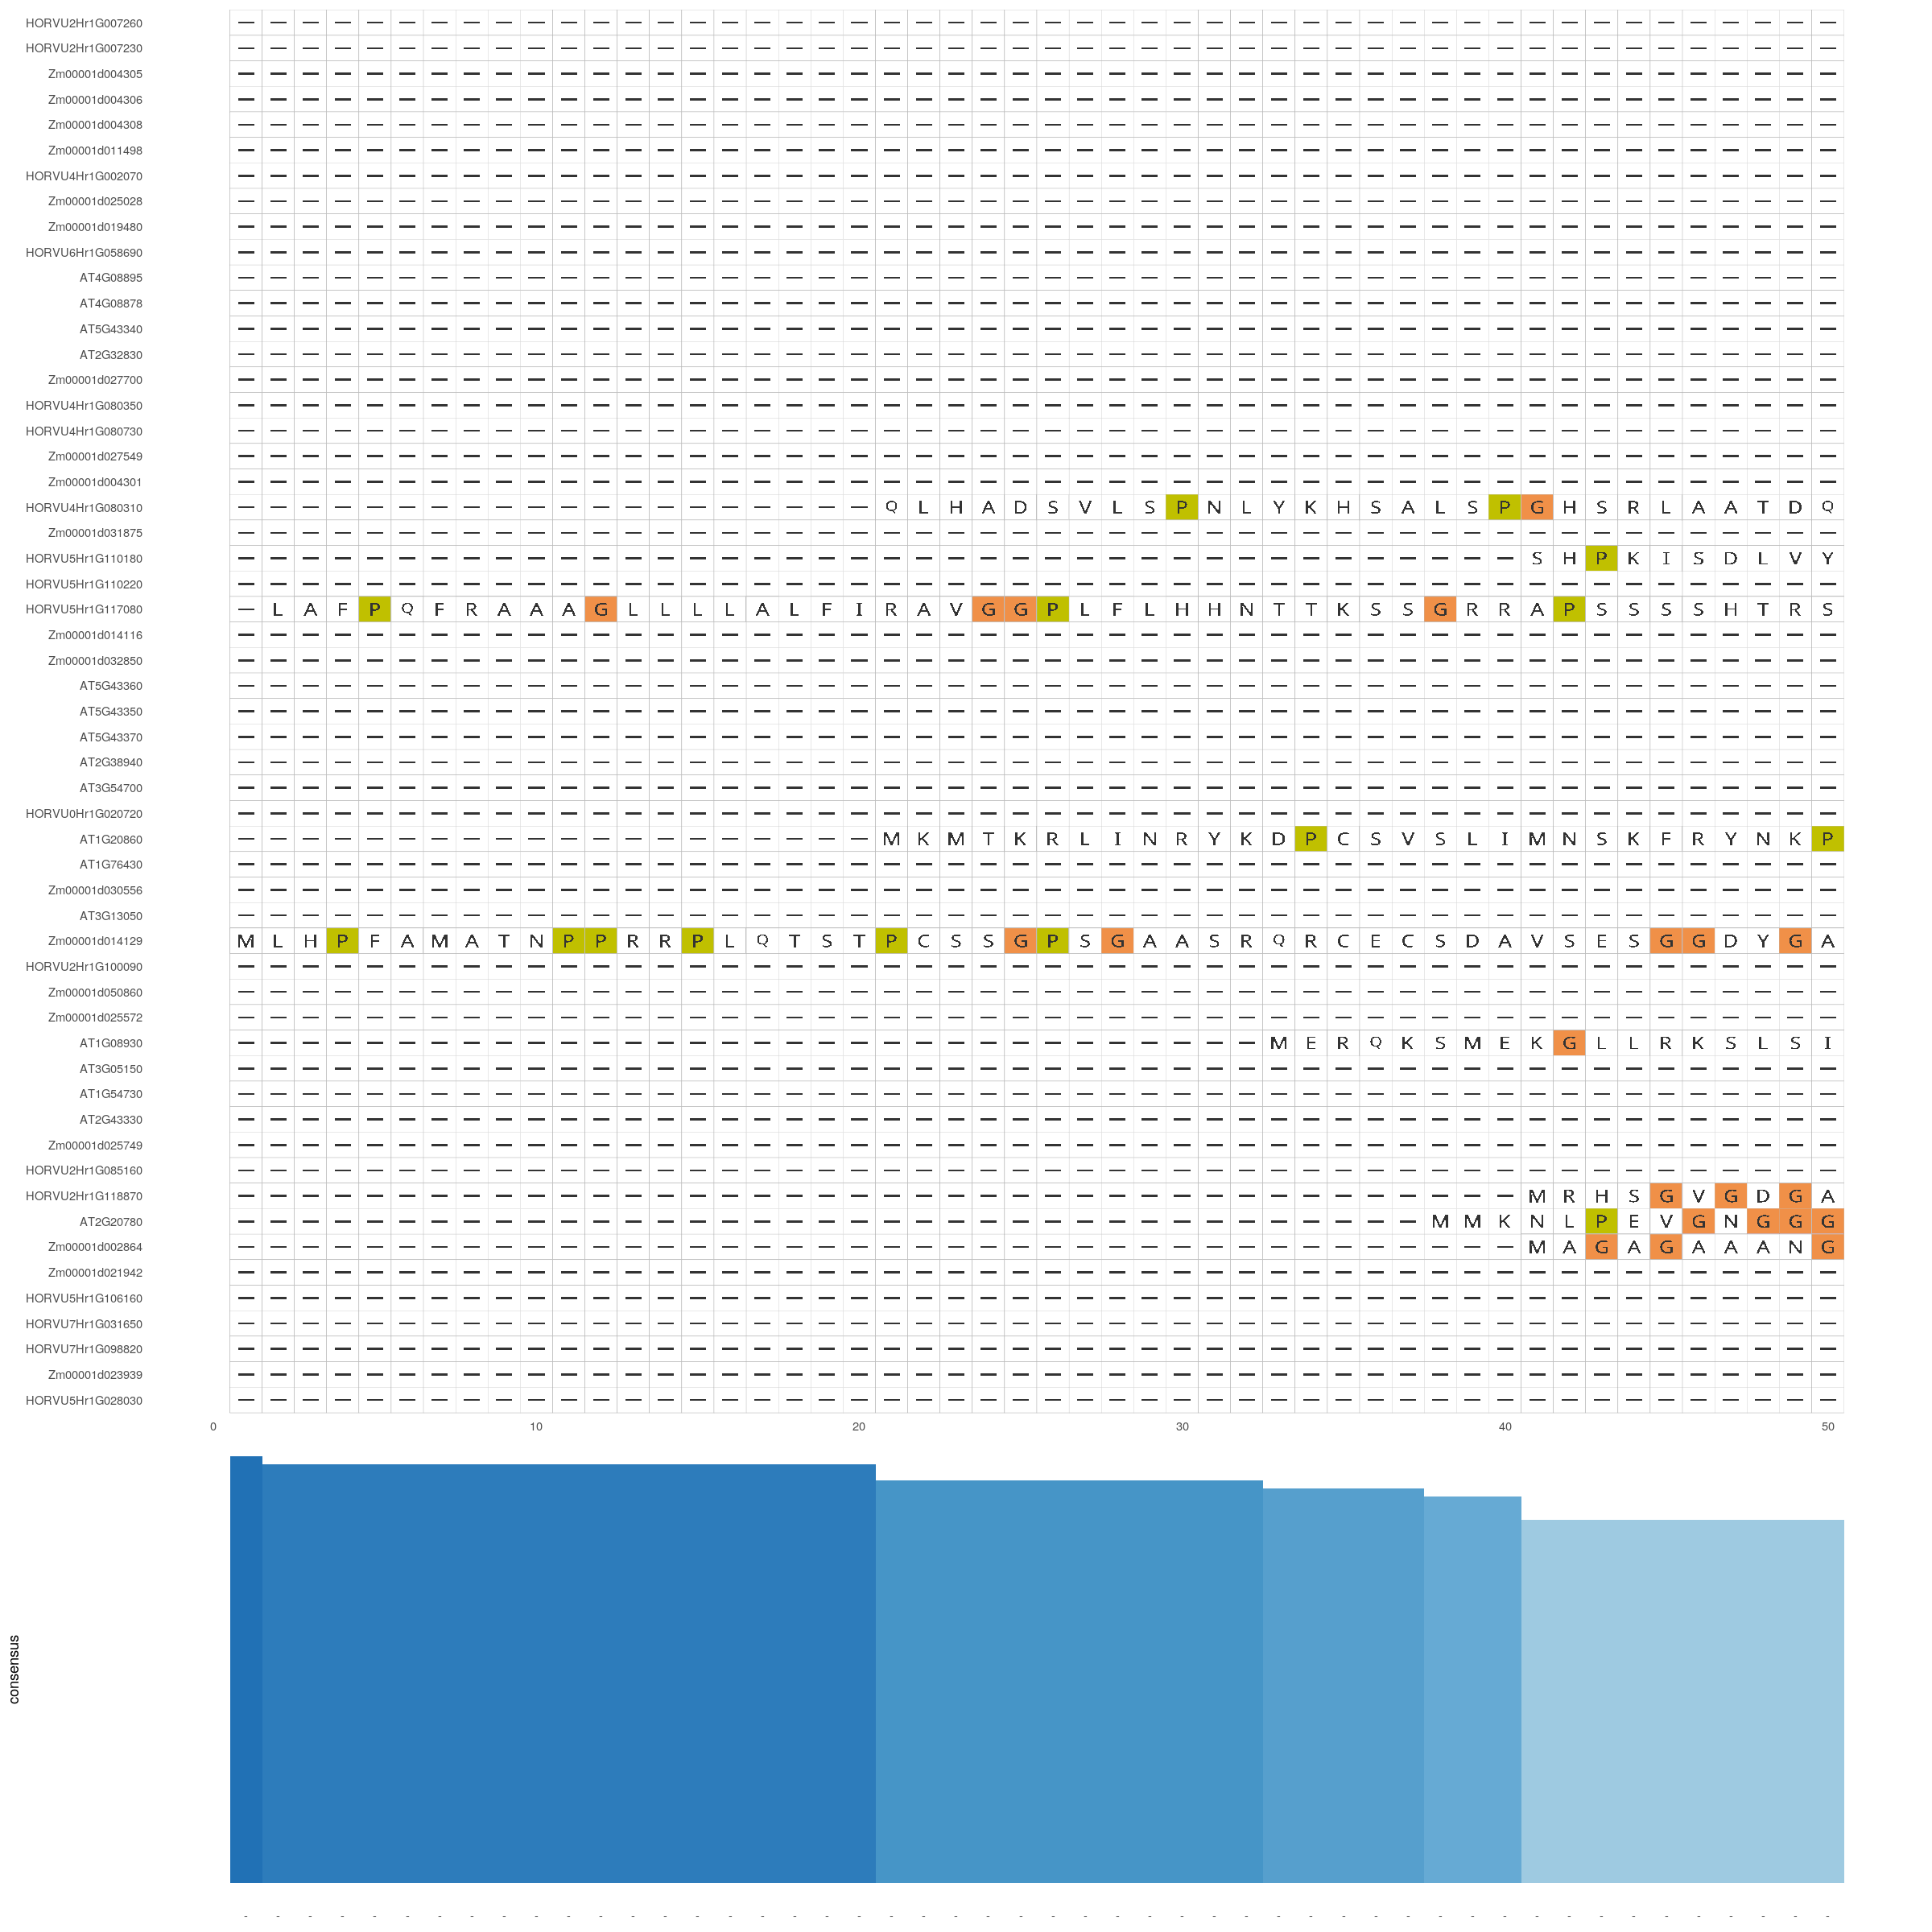

In [5]:
options(repr.plot.width=20, repr.plot.height=20)
options(warn = 2)

load(file = "A2TEA_finished.RData")
#validObject(HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@tree)

a <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@blast_table$qseqid_name
# second: get number of genes in HOG
b <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@num_genes_HOG
# third: get first n unique elements of vector = all genes in HOG 
#unique(a)[1:b]

#available_msa()
#HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000234@fasta_files[[1]][1]
# protein_sequences <- system.file("extdata", "sample.fasta", package = "ggmsa")
#ggmsa(protein_sequences, 300, 350, color = "Clustal", font = "DroidSansMono", char_width = 0.5, seq_name = T )



my_msa <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@msa
my_msa
#my_tidy_msa <- tidy_msa(my_msa, start = NULL, end = NULL)

#filt_vec <- as_vector(HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0005781@genes_HOG)
#filt_vec

#my_msa[filt_vec]

ggmsa(
    my_msa, 1, 50,
    color = "Clustal", 
    font = "DroidSansMono", 
    char_width = 0.5, 
    seq_name = TRUE
     ) + theme(plot.margin = unit(c(100,1,1,1), "cm")) + geom_msaBar() 

### Plotting trees with logFold change info and further annotation, e.g. sig. star symbol

 num 3
 num 3


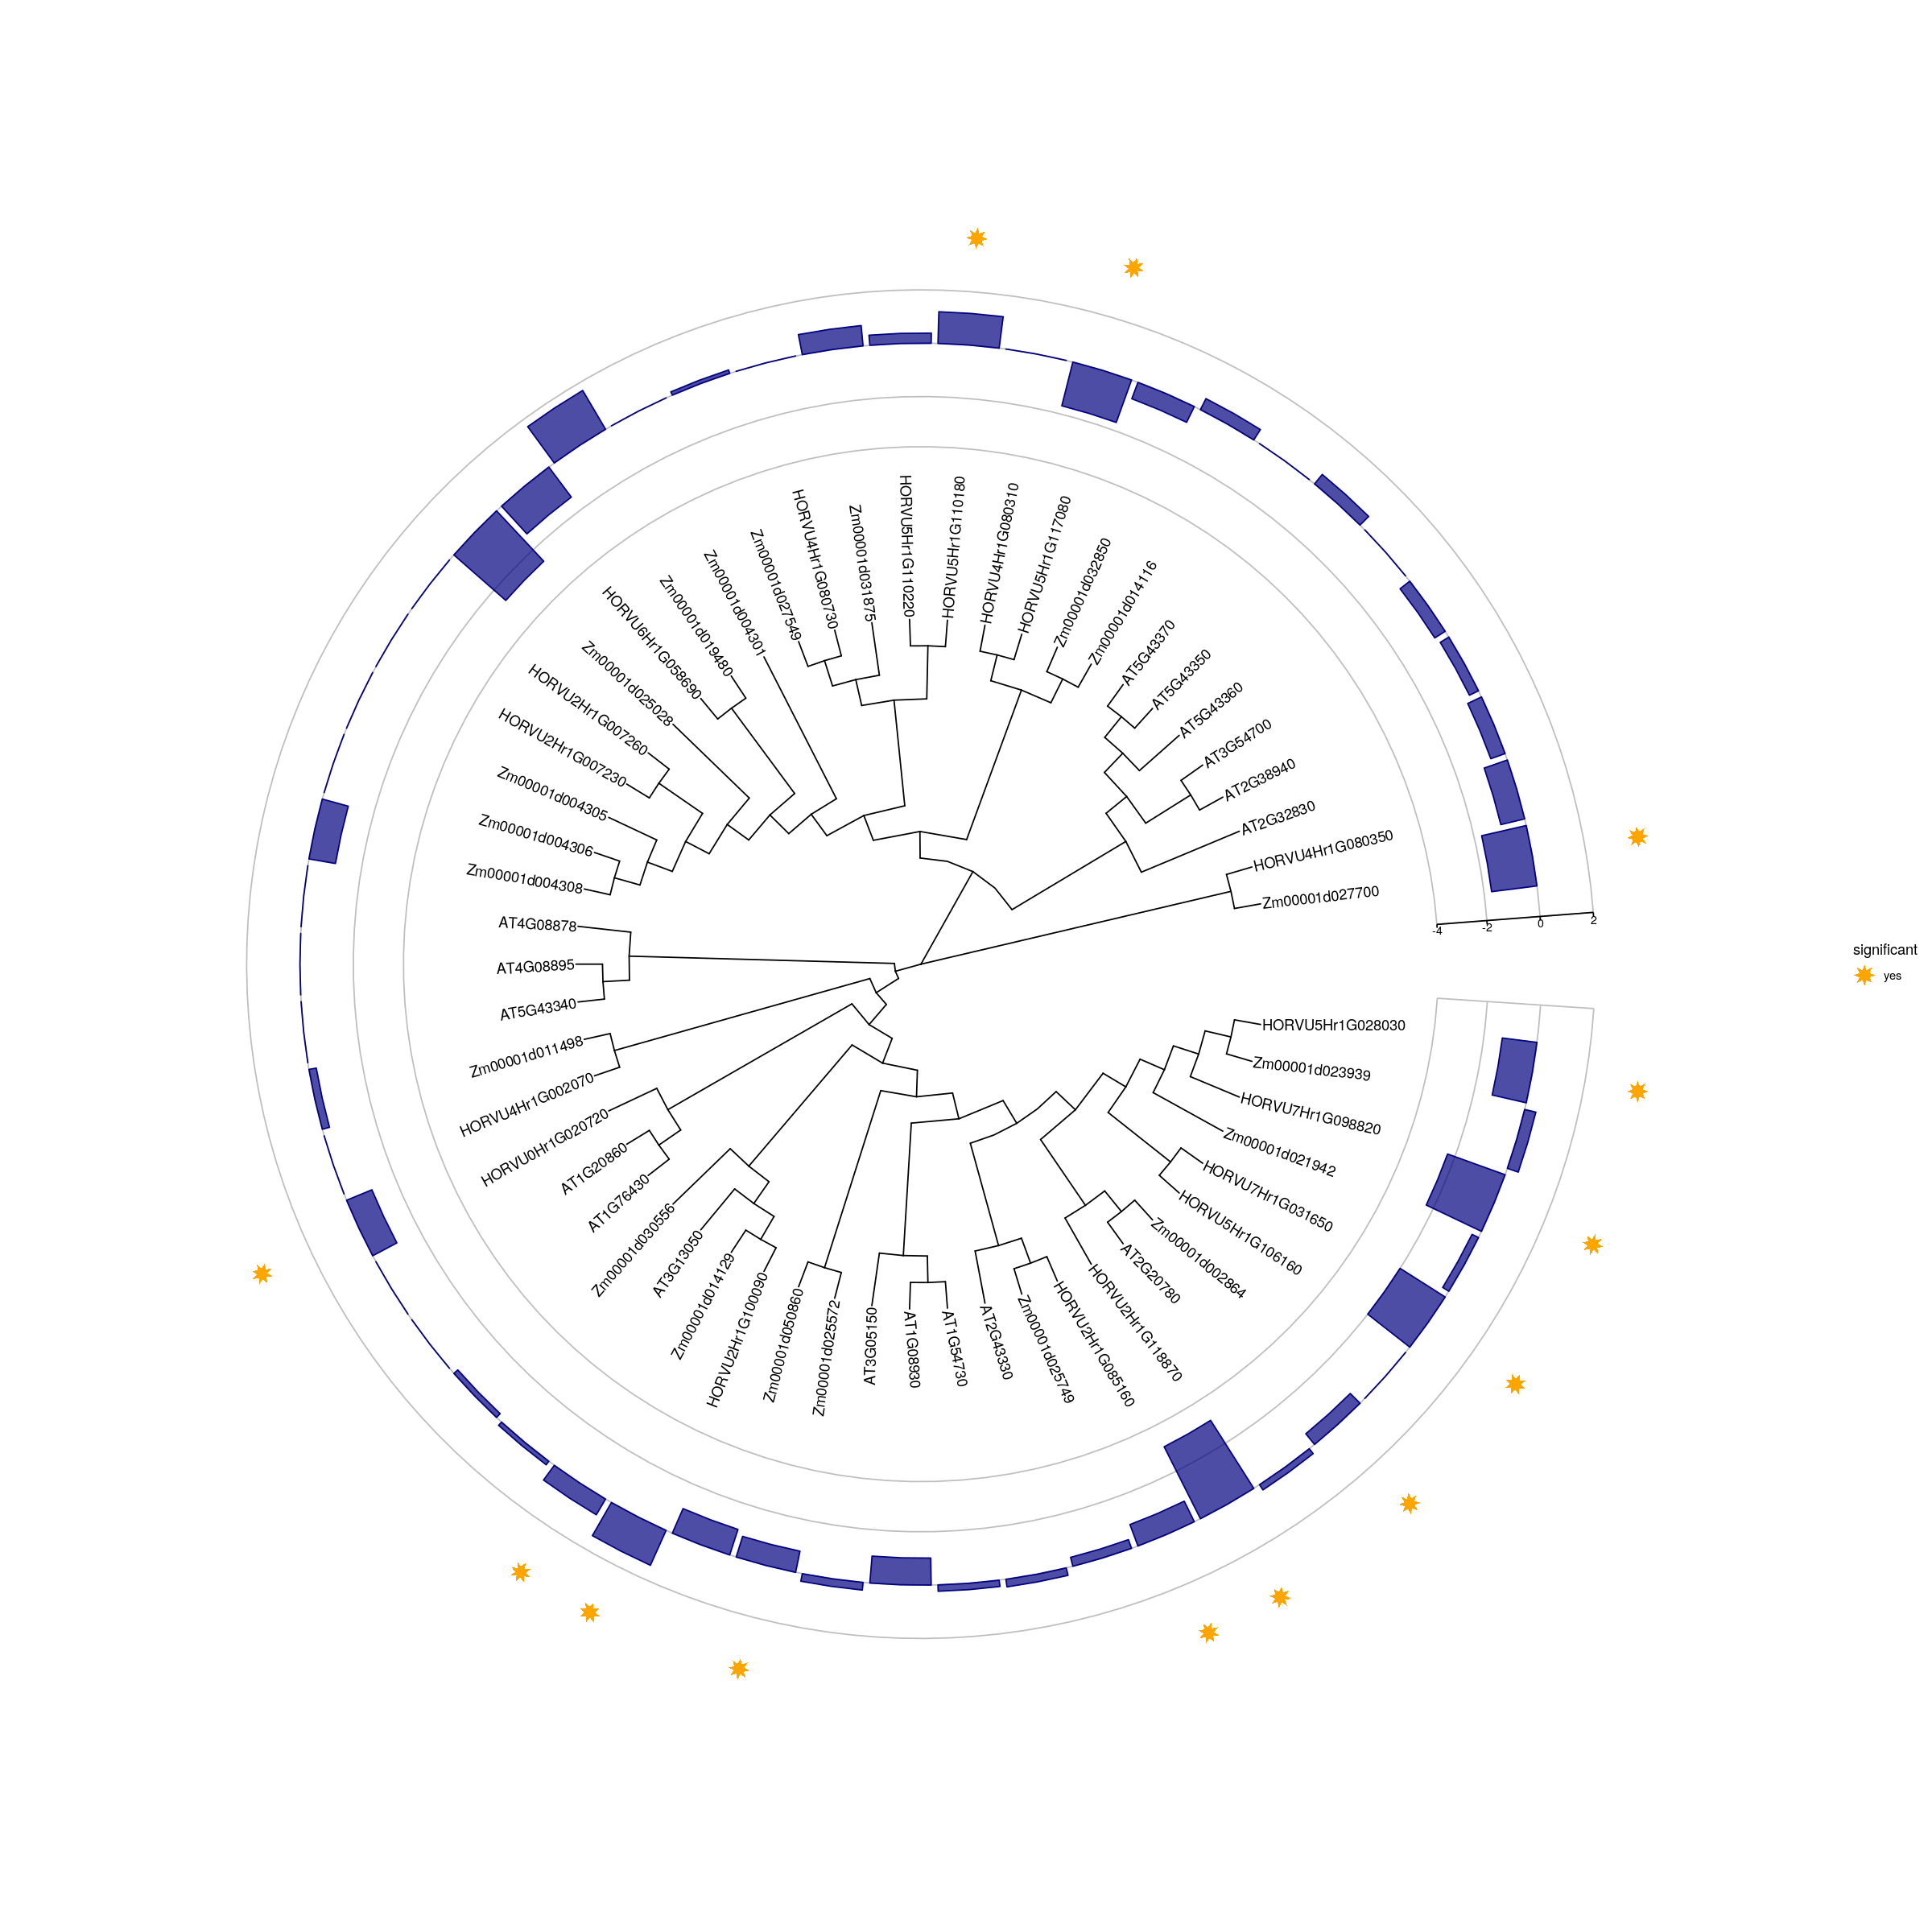

In [52]:
#test tree is:
my_tree <- HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@tree
#my_tree
my_tree_genes <- as_vector(HYPOTHESES.a2tea$hypothesis_1@expanded_OGs$N0.HOG0000207@genes)

#head(HOG_DE.a2tea)

tree_dge <- HOG_DE.a2tea %>%
  filter(gene %in% my_tree_genes) %>%
  replace_na(list(log2FoldChange = 0))
  
tree_dge_only_sig <- HOG_DE.a2tea %>%
  filter(gene %in% my_tree_genes) %>%
  filter(significant == "yes")

#tree_dge

#get max pos/neg log fold change - for automatic breaks in y-axis scale
max_lfc <- tree_dge %>% 
  mutate(arr = abs(log2FoldChange)) %>% #get absolute log2FoldChange
  arrange(desc(arr)) %>% #arrange according to decreasing absolute log2FoldChanges
  slice_head(n = 1) %>%
  pull(arr) %>% floor() 

str(max_lfc)

#if (max_lfc < 5) {
#    max_lfc <- max_lfc + 1
#}
#if (max_lfc > 10) {
#    max_lfc <- max_lfc - 1
#}
str(max_lfc)

ttt <- 4

#tree_dge
#tree_dge_only_sig

p <- ggtree(tr = my_tree, layout = "circular", branch.length = "none", #open.angle=angle  
) + geom_tiplab() + 



geom_fruit(data = tree_dge,
                               geom = geom_bar, 
                               mapping = aes(
                                           y=gene,
                                           x=log2FoldChange,
                                           #color = "navy",
                                           #group=label,
                                           #fill="blue",
                                          ),
                               fill="navy",
                               colour = "navy",
                               alpha=.7,
                               orientation="y",
                               stat="identity",
                               offset = 0.8,
                               pwidth = 0.3,
                               #axis parameters
                               axis.params =
                                 list(
                                   axis = "x", 
                                   text.size = 3, 
                                   nbreak = 3, 
                                   line.size = 0.5, 
                                   line.color = "black"
                                 ),
                               grid.params =
                                 list(
                                   size = 0.5, #color = "navy"
                                 )
                              )
#p
p + geom_fruit(data=tree_dge_only_sig,
                                geom=geom_star,
                                mapping=aes(y=gene, fill=significant),
                                size=5,
                                starstroke=0,
                                starshape = 9,
                                offset = 0.01,
                                #pwidth = 0
                                 ) + 
           # controlling the main color of the sig. star layer here with scale_fill_manual()
           scale_fill_manual(values="orange")


In [50]:
ttt <- 5

ttt %>% head()

pretty.default(1:15, n = eval(ttt))   # 0  5 10 15

[1] 5

[1]  0  2  4  6  8 10 12 14 16

In [14]:
?pretty
#?geom_fruit
#?geom_star
#?geom_bar

In [ ]:
tr <- rtree(100)
dd = data.frame(id=tr$tip.label, value=abs(rnorm(100)))
dt = data.frame(id=tr$tip.label, group=c(rep("A",50),rep("B",50)))
p <- ggtree(tr, layout="circular") 

p <- p + 
      geom_fruit(
          data=dt,
          geom=geom_star,
          mapping=aes(y=id, fill=group),
          size=2.5,
          starstroke=0
      )

p + geom_fruit(
           data=dd,
           geom=geom_bar,
           mapping=aes(x=value, y=id),
           orientation="y",
           stat="identity"
      )



## UpSetR playaround

In [ ]:
# drop columns that are unnecessary and get names of all species columns with total gene count per HOG
workset <- HOG_level_list[[1]] %>% select(ends_with("_total")) %>% names() 
# create copy of HOG_level_list[[1]] to be worked on
work_HOG_level_list <- HOG_level_list[[1]]

for (i in workset) {
    #print(i)
    species_name <- i %>% stringr::str_replace("_total","")
    #print(species_name)
    # create new columns for each species - 0,1 whether they have a gene in each HOG - this is needed or UpSetR
    work_HOG_level_list <- mutate(work_HOG_level_list, !!species_name := ifelse(
                                                      get(i) > 0, as.integer(1), as.integer(0)
                                                         )
         )
}
str(work_HOG_level_list)


#subset_work_HOG_level_list <- work_HOG_level_list %>% select(HOG, Arabidopsis_thaliana, Zea_mays, Hordeum_vulgare)
#str(subset_work_HOG_level_list)

# can't use tibble apparently...
# convert to dataframe first
df_work_HOG_level_list <- as.data.frame(work_HOG_level_list)
str(df_work_HOG_level_list)

df_work_HOG_level_list$Zea_mays_sigDE <- as.numeric(df_work_HOG_level_list$Zea_mays_sigDE)
df_work_HOG_level_list$Zea_mays_sigDE[is.na(df_work_HOG_level_list$Zea_mays_sigDE)] <- 0
#str(df_work_HOG_level_list)


#custom func to colour if sig DE genes from species A. thaliana
Myfunc <- function(row, num) {
    data <- (row["Hordeum_vulgare_sigDE"] > num)
}

#df_work_HOG_level_list %>% filter(!is.na(Zea_mays_sigDE)) %>% head()

upset(df_work_HOG_level_list,
      sets = c("Arabidopsis_thaliana", "Zea_mays", "Hordeum_vulgare"),
      order.by = "freq",
      empty.intersections = "on",
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "HOG Intersections", 
      text.scale = c(2, 1.3, 1, 1, 2, 2),
      sets.bar.color = "navy",
      queries = list(list(query = Myfunc, params=list(3), color = "green", active = T))
     )

In [ ]:
# creating upsetR Plot
head(HOG_level_list[[1]])

workset <-  HOG_level_list[[1]]
# drop columns that are unnecessary
workset <- workset %>% select(HOG, ends_with("_total")) 
# add this point we can easily compute the number of species/ecotypes etc. 
# #species = (columns of current workset - 1) 
species_num <- ncol(workset) - 1
# change 0 to NAs since we can more easily filter on that
is.na(workset) <- workset==0
# remove '_total' from column names
#str_remove(colnames(workset), "_total")
workset <- workset %>% setNames(names(workset) %>% stringr::str_replace("_total",""))

head(workset)

genotypeList <- list()
for (j in 1:species_num) {
    assign(paste0("Genotype", j), as.vector(simplify_all(workset[!is.na(workset[j+1]),"HOG"])[[1]]))
    subList <- list(get(paste0("Genotype", j)))
    names(subList) <- colnames(workset)[j+1]
    genotypeList <- c(genotypeList, subList)
}

#head(genotypeList)

#using UpSetR
upsetOrtho <- upset(fromList(genotypeList), 
                    order.by = "freq",
                    empty.intersections = "on",
                    point.size = 3.5, 
                    line.size = 2, 
                    mainbar.y.label = "HOG Intersections", 
                    text.scale = c(2, 1.3, 1, 1, 2, 2),
                    main.bar.color = "navy",
                    matrix.color = "navy",
                    sets.bar.color = "navy"
                   )

upsetOrtho

ggvenn(genotypeList, stroke_linetype = 2, text_size = 5, set_name_color = "navy",
       stroke_color = "yellow3",
       stroke_size = 0.8, 
       set_name_size = 6, 
       show_percentage = TRUE, 
       fill_color = c("yellow", "purple", "papayawhip", "red4")
      )